## Modeling Inspection of the Food Establishments in the City of Chicago

## Project Plan
 - Project Goal
 - Dataset and features
 - Exploratory data analysis (EDA) 
 - Patterns, insights, pecularities of data
 - Data preprocessing
 - Feature engineering and description
 - Cross-validation, hyperparameter tuning
 - Validation and learning curves
 - Prediction for hold-out and test samples
 - Model evaluation with metrics description
 - Conclusions


### Project Goal
The goal of this project is to model the vilolations/failures by the food establishments in the city of chicago. 

### Data Set and Features  
We used city of Chicago's Socrata Open Data (SODA) API to acess food inspection data for 2018 and 2019. In addition to the food inspection data, we are using burglary/crime, 311 sanitation complaints, businesss license data as well.

## Exploratory Data Analysis 

In [1]:
#important libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
sns.set(rc={'figure.figsize':(12, 6),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="darkgrid")
import matplotlib.dates as mdates
import re
from datetime import datetime, timedelta
import time
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import LabelEncoder
from geopy import distance
import geopy.distance
import swifter
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc


In [2]:
food_data = pd.read_json('../data/raw/food-inspection.json', convert_dates = ['inspection_date'])

In [3]:
food_data.head(2)

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license_,location,longitude,results,risk,state,violations,zip
0,6136 S PULASKI RD,BELLA LUNA BAR,CHICAGO,BELLA LUNA BAR,BANQUET HALL,2017-01-03,1978834,License Re-Inspection,41.781158,2476443.0,"{'type': 'Point', 'coordinates': [-87.72297770...",-87.722978,Pass,Risk 3 (Low),IL,None,60629.0
1,2216 S MICHIGAN AVE,JAMAICA JERK VILLA,CHICAGO,JAMAICA JERK VILLA,Restaurant,2017-01-03,1978825,License,41.852341,2464559.0,"{'type': 'Point', 'coordinates': [-87.62393736...",-87.623937,Not Ready,Risk 1 (High),IL,None,60616.0


In [4]:
food_data.rename(columns={'license_':'license'}, inplace=True)

In [5]:
shape = food_data.shape
print(" So there are %d rows and %d columns in the data" % (shape[0], shape[1]))

 So there are 44760 rows and 17 columns in the data


In [6]:
food_data.isna().sum()

address                0
aka_name             190
city                  48
dba_name               0
facility_type        277
inspection_date        0
inspection_id          0
inspection_type        0
latitude             178
license                2
location             178
longitude            178
results                0
risk                  17
state                 27
violations         11141
zip                    9
dtype: int64

Let us do some data clean up:

In [7]:
food_data = food_data[np.isfinite(food_data['license'])]
food_data = food_data[ (food_data['license'] > 0) & (food_data['inspection_date'] != 0) ]
food_data = food_data.drop(['location', 'zip', 'state', 'city'], axis=1)
food_data['latitude'].fillna(food_data['latitude'].mode()[0], inplace=True)
food_data['longitude'].fillna(food_data['longitude'].mode()[0], inplace=True)
food_data['aka_name'].fillna(food_data['dba_name'], inplace=True)
food_data['license'] = food_data['license'].astype('int')

In [8]:
food_data.isna().sum()

address                0
aka_name               0
dba_name               0
facility_type        274
inspection_date        0
inspection_id          0
inspection_type        0
latitude               0
license                0
longitude              0
results                0
risk                  16
violations         11122
dtype: int64

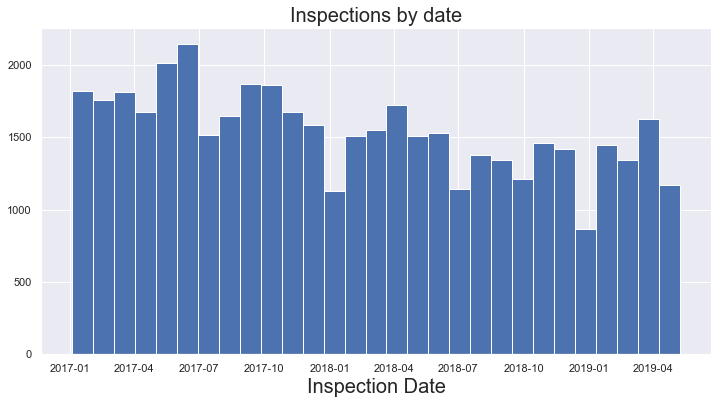

In [9]:
plt.figure(figsize=(12, 6))
#food_data.unstack.plot(['inspection_date'].hist(bins=16, use_index=True)
food_data['inspection_date'].hist(bins =29)
plt.title("Inspections by date")
plt.xlabel("Inspection Date")
plt.show()

In [10]:
#what's in the data? 
food_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44687 entries, 0 to 9999
Data columns (total 13 columns):
address            44687 non-null object
aka_name           44687 non-null object
dba_name           44687 non-null object
facility_type      44413 non-null object
inspection_date    44687 non-null datetime64[ns]
inspection_id      44687 non-null int64
inspection_type    44687 non-null object
latitude           44687 non-null float64
license            44687 non-null int64
longitude          44687 non-null float64
results            44687 non-null object
risk               44671 non-null object
violations         33565 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 4.8+ MB


In [11]:
#simple statistics 
food_data.describe().T
#food_data.set_index('inspection_date')

,count,mean,std,min,25%,50%,75%,max
inspection_id,44687.0,2.129673e+06,97499.599578,263804.000000,2.064474e+06,2.135501e+06,2.213734e+06,2.288551e+06
latitude,44687.0,4.188597e+01,0.080434,41.644670,4.184729e+01,4.189389e+01,4.194378e+01,4.202106e+01
license,44687.0,1.849083e+06,896344.053213,2.000000,1.594476e+06,2.215928e+06,2.475923e+06,3.808890e+06
longitude,44687.0,-8.767813e+01,0.060751,-87.914428,-8.770784e+01,-8.766634e+01,-8.763630e+01,-8.752509e+01


In [12]:
def count_violations(row):
    if row['violations'] is None:
        return [0]
    else:
        serious_violations_count = 0
        critical_violations_count = 0
        minor_violations_count = 0
        x = row['violations'].split('|')
        if row['inspection_date'] < pd.to_datetime('2018-07-01'):
            codes = []
            for violation in x:
                match = int(re.search('[0-9]+', violation).group())
                #print(match)
                codes.append(match)
            for code in codes:
                if  code < 15:
                    critical_violations_count += 1
                elif code > 15 and code < 30:
                    serious_violations_count += 1
                elif code > 30 and code < 45:
                    minor_violations_count += 1
            return [minor_violations_count, serious_violations_count, critical_violations_count]
        else:
            for violation in x:
                if 'PRIORITY VIOLATION' in violation:
                        critical_violations_count += 1
                elif 'PRIORITY FOUNDATION VIOLATION' in violation:
                        serious_violations_count += 1
                elif 'CORE VIOLATION' in violation:
                        minor_violations_count += 1
            return [minor_violations_count, serious_violations_count, critical_violations_count]
     

In [13]:
food_data['violations_list'] = food_data.apply(lambda x : count_violations(x), axis=1)
food_data['minor_violations'] = food_data['violations_list'].apply(lambda x : x[0])
food_data['serious_violations'] = food_data['violations_list'].apply(lambda x : x[1] if len(x) > 1 else 0)
food_data['critical_violations'] = food_data['violations_list'].apply(lambda x : x[2] if len(x) > 1 else 0)
food_data['CriticalFound'] = food_data['critical_violations'].apply(lambda x: 1 if x > 0 else 0)

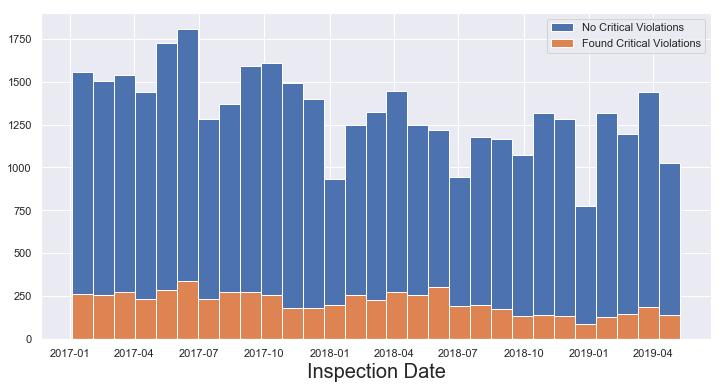

In [14]:
plt.figure(figsize=(12, 6))
food_data[food_data['CriticalFound'] == 0]['inspection_date'].hist(bins=29,label = "No Critical Violations")
food_data[food_data['CriticalFound'] == 1]['inspection_date'].hist(bins=29,label = "Found Critical Violations")
plt.xlabel("Inspection Date")
plt.legend(loc='best')
plt.show()

In [15]:
food_data.head()

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,violations,violations_list,minor_violations,serious_violations,critical_violations,CriticalFound
0,6136 S PULASKI RD,BELLA LUNA BAR,BELLA LUNA BAR,BANQUET HALL,2017-01-03,1978834,License Re-Inspection,41.781158,2476443,-87.722978,Pass,Risk 3 (Low),None,[0],0,0,0,0
1,2216 S MICHIGAN AVE,JAMAICA JERK VILLA,JAMAICA JERK VILLA,Restaurant,2017-01-03,1978825,License,41.852341,2464559,-87.623937,Not Ready,Risk 1 (High),None,[0],0,0,0,0
10,2000 W ROSCOE ST,COMMONWEALTH TAVEN,"ROSCOE-DAMEN, CORP.",Restaurant,2017-01-03,1978836,Canvass,41.943325,2293828,-87.678514,Pass w/ Conditions,Risk 1 (High),8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,"[2, 0, 1]",2,0,1,1
100,619 N WABASH AVE,PIZZERIA DUE,PIZZERIA DUE,Restaurant,2017-01-04,1978927,Canvass,41.893185,1331225,-87.626610,Pass,Risk 1 (High),33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,"[2, 0, 0]",2,0,0,0
1000,7350 S Evans,HENRY O. TANNER ELEMENTARY,HENRY O. TANNER ELEMENTARY,School,2017-01-20,1981776,Canvass,41.760699,26281,-87.606828,Pass,Risk 1 (High),"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...","[2, 0, 0]",2,0,0,0


#### Let's drop some redudant and unnecessary columns from the dataframe and also clean up column_names.

In [16]:
food_data = food_data.drop(['violations_list', 'violations'], axis=1)

In [17]:
food_data.head(2)

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,serious_violations,critical_violations,CriticalFound
0,6136 S PULASKI RD,BELLA LUNA BAR,BELLA LUNA BAR,BANQUET HALL,2017-01-03,1978834,License Re-Inspection,41.781158,2476443,-87.722978,Pass,Risk 3 (Low),0,0,0,0
1,2216 S MICHIGAN AVE,JAMAICA JERK VILLA,JAMAICA JERK VILLA,Restaurant,2017-01-03,1978825,License,41.852341,2464559,-87.623937,Not Ready,Risk 1 (High),0,0,0,0


In [18]:
food_data[food_data['license'] == 2]

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,serious_violations,critical_violations,CriticalFound
23716,230 W MONROE ST,COSI,COSI,Restaurant,2018-02-13,2144871,Canvass,41.880757,2,-87.634709,Pass w/ Conditions,Risk 1 (High),1,0,1,1
7990,230 W MONROE ST,COSI,COSI,Restaurant,2017-05-12,2050308,Canvass,41.880757,2,-87.634709,Pass,Risk 1 (High),4,0,0,0


In [19]:
food_data.isna().sum()

address                  0
aka_name                 0
dba_name                 0
facility_type          274
inspection_date          0
inspection_id            0
inspection_type          0
latitude                 0
license                  0
longitude                0
results                  0
risk                    16
minor_violations         0
serious_violations       0
critical_violations      0
CriticalFound            0
dtype: int64

#### Let's see the frequency of these inspections. 

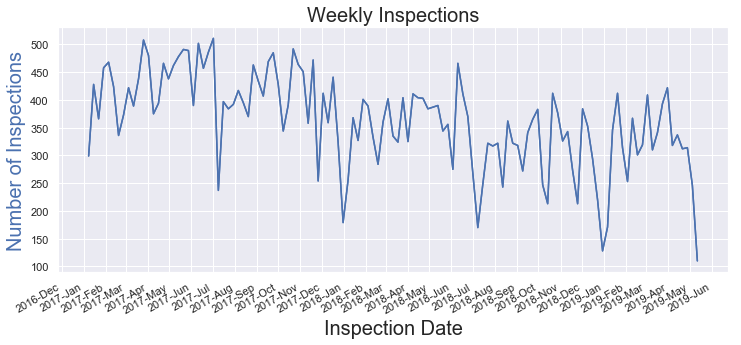

In [20]:
per_day = pd.DataFrame()
per_day =  food_data[['inspection_date', 'inspection_id']]
per_day = per_day.set_index(pd.to_datetime(per_day['inspection_date']))
per_day = per_day.resample('W').count()
plt.rcParams['figure.figsize'] = 12,5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(per_day.index, per_day, 'b-')
plt.xlabel('Inspection Date')
plt.ylabel('Number of Inspections', color='b')
plt.title('Weekly Inspections')
plt.show()

In [21]:
print("%s unique facilites were inspected during the period" %food_data['license'].nunique())

16275 unique facilites were inspected during the period


### Let's look at the results of these inspection more closely: 
A facility can either pass, pass with conditions or fail. Following is an excerpt from the dataset documentation page:

"Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such".

In [22]:
food_data['results'].value_counts()

Pass                    19919
Pass w/ Conditions      10023
Fail                     8506
Out of Business          3064
No Entry                 2122
Not Ready                1045
Business Not Located        8
Name: results, dtype: int64

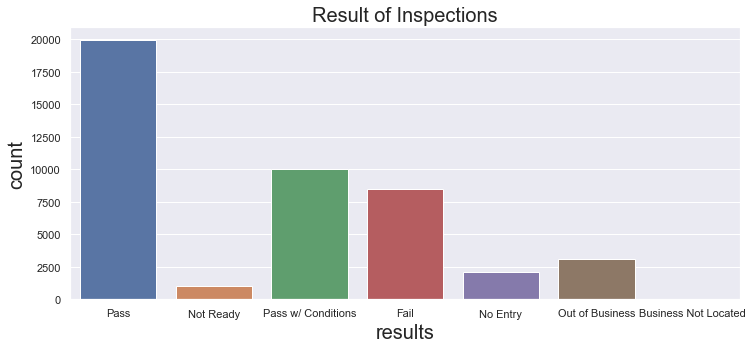

In [23]:
ax = sns.countplot(x="results", data=food_data)
plt.title("Result of Inspections")
plt.show()

### Let's convert results in to categorical variable first and the we will filter out non-relevant categories like 'Out of Business', 'Not Ready' and 'No Entry' facilities. 

In [24]:
results_conv = {"results" : {"Fail" : 0, "Pass" : 1, "Pass w/ Conditions" : 1, "Out of Business": 2, "No Entry": 3 , "Not Ready": 4, 'Business Not Located' : 5}}
food_data.replace(results_conv, inplace=True)
print(food_data.results.dtype)

int64


In [25]:
food_data = food_data[food_data['results'] < 2]

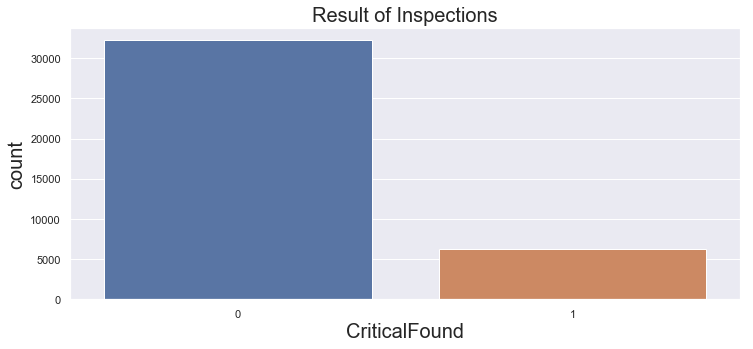

In [26]:
ax = sns.countplot(x="CriticalFound", data=food_data)
plt.title("Result of Inspections")
plt.show()

This clearly shows more the number of critical violations, more the failure rate.  

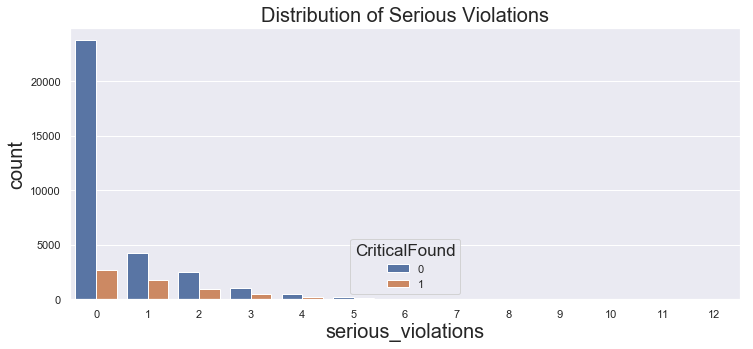

In [27]:
# how about non_critical_violations ? 
ax = sns.countplot(x="serious_violations", hue = 'CriticalFound', data=food_data)
plt.title("Distribution of Serious Violations")
plt.show()

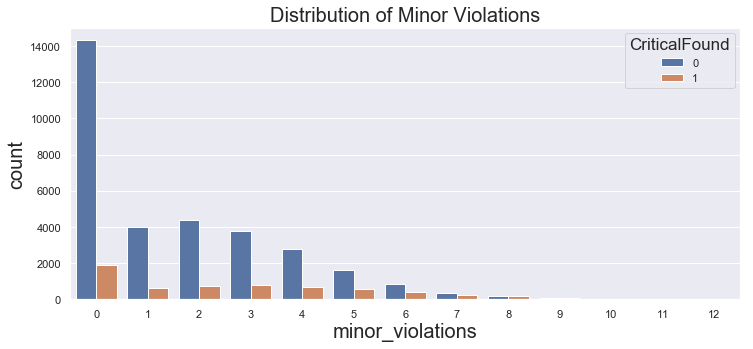

In [28]:
# how about non_critical_violations ? 
ax = sns.countplot(x="minor_violations", hue = 'CriticalFound', data=food_data)
plt.title("Distribution of Minor Violations")
plt.show()

###  Inspection type: 
According to the dataset description, an inspection can be of the following types:

1) Canvass : The most common type of inspection performed at a frequency relative to the risk of the establishment

2) Consultation: when the inspection is done at the request of the owner prior to the opening of the establishment

3) Complaint: when the inspection is done in response to a complaint against the establishment

4) license : when the inspection is done as a requirement for the establishment to receive its license to operate

5) suspect food poisoning : when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint based inspection)

6) Task-force inspection: when an inspection of a bar or tavern is done.

7) Re-inspections:  Occurs for most types of these inspections and are indicated as such.pe



In [29]:
food_data['inspection_type'].value_counts()

Canvass                                   18688
License                                    5272
Canvass Re-Inspection                      5171
Complaint                                  4378
Complaint Re-Inspection                    1834
License Re-Inspection                      1808
Short Form Complaint                        997
Suspected Food Poisoning                    153
Recent Inspection                           103
Suspected Food Poisoning Re-inspection       28
Consultation                                 11
Non-Inspection                                4
Recent inspection                             1
Name: inspection_type, dtype: int64

#### A picture speaks thousands numbers, right ? Let's look at these numbers as count plots. 

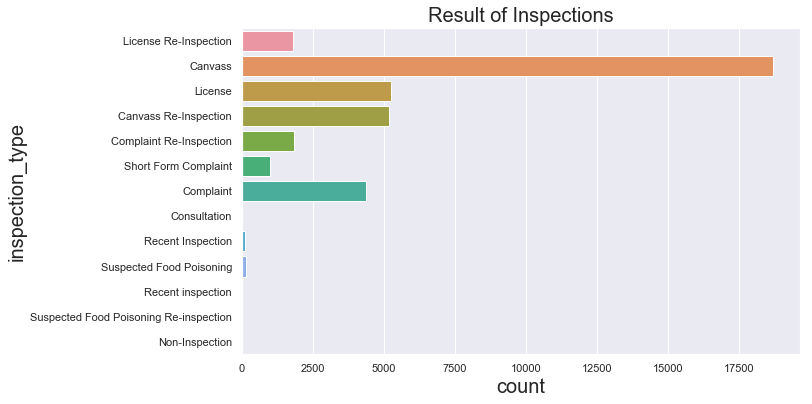

In [30]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y="inspection_type", data=food_data)
plt.title("Result of Inspections")
plt.show()

#### Since our goal is here to model the failure in random canvas, we are going to focus on canvass inspections only. 

In [31]:
food_data = food_data[food_data['inspection_type'] == 'Canvass']

In [32]:
#food_data = food_data[(food_data['results']== 1) | (food_data['results']== 2) ]

In [33]:
print("%d different types of food establishment facilities were inspected during the period and %d different types of inpsections were conducted during the period."% 
(food_data['facility_type'].nunique(), food_data['inspection_type'].nunique()))

144 different types of food establishment facilities were inspected during the period and 1 different types of inpsections were conducted during the period.


In [34]:
plt.figure(figsize=(13, 13))
food_data['facility_type'].value_counts()[0:10]

Restaurant                         13071
School                              2238
Grocery Store                       1241
Children's Services Facility         396
Bakery                               261
Long Term Care                       247
Daycare Above and Under 2 Years      230
Daycare (2 - 6 Years)                199
Catering                             126
Hospital                             100
Name: facility_type, dtype: int64

<Figure size 936x936 with 0 Axes>

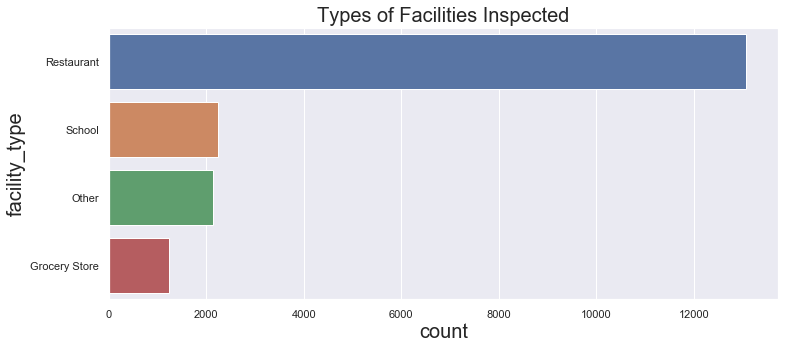

In [35]:
# Setting anything other than Restaurants, Grocery store and School to other types
ftype = lambda x: "Other" if x not in ['Restaurant', 'Grocery Store', 'School'] else x
food_data['facility_type'] = food_data['facility_type'].map(ftype)
ax = sns.countplot(y="facility_type", data=food_data)
plt.title("Types of Facilities Inspected")
plt.show()

In [36]:
food_data = food_data[(food_data['facility_type'] == 'Restaurant') | (food_data['facility_type'] == 'Grocery Store')]

In [37]:
food_data.sort_values(by = 'inspection_date', inplace=True)
#food_data.set_index(['date'])
#food_data = food_data.set_index(['inspection_date'])
#food_data = food_data.sort_values(by=['inspection_date'], ascending=False)
#food_data['time_since_last_inspection'] = food_data.groupby(['license'])['inspection_date'].shift(-1)
#food_data[food_data['license'] == 28176]

### Risk categories: 
    
Each establishment is categorized as to its risk of adversely affecting the public’s health:

 1: High

 2: Medium 

 3: Low 

The frequency of inspection is tied to this risk, with risk 1 establishments inspected most frequently and risk 3 least frequently.

In [38]:
food_data['risk'].value_counts()[0:10]

Risk 1 (High)      12250
Risk 2 (Medium)     1851
Risk 3 (Low)         211
Name: risk, dtype: int64

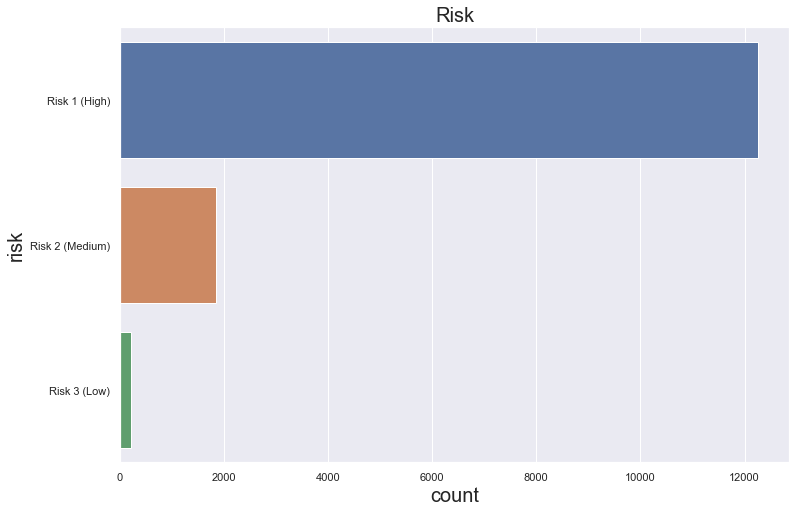

In [39]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(y="risk", data=food_data)
plt.title("Risk")
plt.show()

## Label Encoding categorical variables:

There are couple different ways of label encoding categorical variables.

1) First method is to replace those variables with a dictionary involving key and value pairs of the variables to be encoded. 

2) Another method is to change their type as categorical variable. Let's convert inspection_type for example as as categorical variable. 

In [40]:
#food_data["inspection_type"] = food_data["inspection_type"].astype('category')
food_data["facility_type"] = food_data["facility_type"].astype('category')
food_data["risk"] = food_data["risk"].astype('category')
#food_data["inspection_type_cat"] = food_data["inspection_type"].cat.codes
food_data["facility_type_cat"] = food_data["facility_type"].cat.codes
food_data["risk_type_cat"] = food_data["risk"].cat.codes

In [41]:
food_data.isna().sum()

address                0
aka_name               0
dba_name               0
facility_type          0
inspection_date        0
inspection_id          0
inspection_type        0
latitude               0
license                0
longitude              0
results                0
risk                   0
minor_violations       0
serious_violations     0
critical_violations    0
CriticalFound          0
facility_type_cat      0
risk_type_cat          0
dtype: int64

#### I want to see look these establishments in the map. For plotting, let's divide them into pass and fail data frames.

In [42]:
pass_inspection = food_data[(food_data['results']== 1)]
fail_inspection = food_data[food_data['results']== 0]

### Let's utilize plotly and mapbox to display these restaurants in a map:

In [43]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='dipakrimal', api_key='0d7jgOoPDZTZV2J0l5u4')
mapbox_access_token = "pk.eyJ1IjoiZGlwYWtyaW1hbCIsImEiOiJjanR0NHp5Z3gxOGVtNGVsbHIxOGI3ZmV6In0.bmrI81LR7L441sUKqDeKmw"

data_pass = [
    go.Scattermapbox(
        lat=pass_inspection['latitude'],
        lon=pass_inspection['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(50, 200, 55)',
            opacity=0.7
        ),
        text = pass_inspection['dba_name']  + ' <br> Pass ',
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=fail_inspection['latitude'],
        lon=fail_inspection['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12, 
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
         text = fail_inspection['dba_name'] + ' <br> Fail ',
         hoverinfo='text'
    )   
]

layout = go.Layout(
    title = "Chicago Food Insepections",
    width=600,
    height=800,
    showlegend=False,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=41.9,
            lon=-87.7
        ),
        pitch=10,
        zoom=9,
        style='outdoors'
    ),
)

fig = go.Figure(data=data_pass, layout=layout)

py.iplot(fig, filename='Chicago')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~dipakrimal/0 or inside your plot.ly account where it is named 'Chicago'


/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [44]:
print(food_data.shape)

(14312, 18)


In [45]:
food_data.head(5)

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,serious_violations,critical_violations,CriticalFound,facility_type_cat,risk_type_cat
10,2000 W ROSCOE ST,COMMONWEALTH TAVEN,"ROSCOE-DAMEN, CORP.",Restaurant,2017-01-03,1978836,Canvass,41.943325,2293828,-87.678514,1,Risk 1 (High),2,0,1,1,1,0
16,1508-1512 W BERWYN AVE,RANALLIS,RANALLIS,Restaurant,2017-01-03,1978841,Canvass,41.978123,1738099,-87.668756,1,Risk 1 (High),3,0,0,0,1,0
6,3208 N Pulaski RD,Papa Ray's Pizza & Wings,Papa Ray's Pizza & Wings,Restaurant,2017-01-03,1978842,Canvass,41.939372,2069677,-87.727341,0,Risk 1 (High),4,1,0,0,1,0
14,1353-1355 W FULLERTON AVE,MO'S ASIAN BISTRO,MO'S ASIAN BISTRO,Restaurant,2017-01-03,1978837,Canvass,41.925118,2379500,-87.662634,1,Risk 1 (High),7,1,0,0,1,0
7,2045 N WESTERN AVE,LAS ASADAS FRESH MEXICAN GRILL-TAQUERIA,LAS ASADAS,Restaurant,2017-01-03,1978833,Canvass,41.918871,2069204,-87.687305,1,Risk 1 (High),3,0,0,0,1,0


In [46]:
#df = food_data.groupby(['license'])

In [47]:
weather = pd.read_csv('../data/raw/weather.csv', index_col='DATE', parse_dates=['DATE'])
weather = weather[weather['STATION'] == "USW00094846"]
weather.head()

,STATION,NAME,TAVG,TMAX,TMIN,TOBS
DATE,,,,,,
2017-01-01,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",27.0,40.0,17.0,NaN
2017-01-02,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",34.0,40.0,25.0,NaN
2017-01-03,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",38.0,39.0,19.0,NaN
2017-01-04,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",18.0,19.0,7.0,NaN
2017-01-05,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",9.0,13.0,3.0,NaN


,STATION,NAME,TAVG,TMAX,TMIN,TOBS,TMAXAVG
DATE,,,,,,,
2017-01-01,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",27.0,40.0,17.0,NaN,40.000000
2017-01-02,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",34.0,40.0,25.0,NaN,40.000000
2017-01-03,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",38.0,39.0,19.0,NaN,39.666667
2017-01-04,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",18.0,19.0,7.0,NaN,32.666667
2017-01-05,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",9.0,13.0,3.0,NaN,23.666667


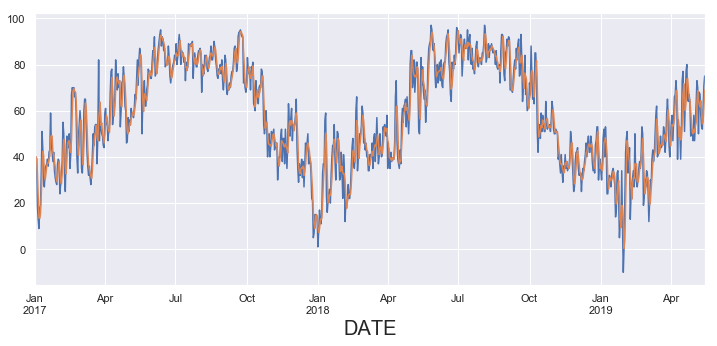

In [48]:
weather['TMAX'].plot()
weather['TMAXAVG'] = weather['TMAX'].rolling(window=3, min_periods=1).mean()
weather['TMAXAVG'].plot()
weather.head()

In [49]:
food_data = pd.merge(left=food_data, right=weather, left_on='inspection_date', right_on='DATE')

In [50]:
food_data.shape

(14312, 25)

In [51]:
#food_data['date'] = food_data['inspection_date']
#food_data['bus_license'] = food_data['license']
#food_data = food_data.set_index(['date', 'license'])

## Burglary Data
Is there any connection with the crime and food inspection failures? May be ! For now, I am focusing on the burgalaries only. The burglary data is the chicago's crime data filtered for burgalaries only (in the same time window i.e. first 3 months of 2019). 

In [52]:
burglary = pd.read_json('../data/raw/burglary.json', convert_dates = ['date'])

In [53]:
burglary.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,location_description,location_state,location_zip,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,False,835,026XX W 79TH ST,JB147595,70,2017-03-28 14:00:00,UNLAWFUL ENTRY,8,False,5,...,OTHER,None,None,NaN,BURGLARY,2018-02-11T15:57:41.000,18,NaN,NaN,2017
1,False,511,102XX S EBERHART AVE,JB148941,49,2017-12-16 14:30:00,FORCIBLE ENTRY,5,False,5,...,VACANT LOT/LAND,None,None,NaN,BURGLARY,2018-02-12T15:49:14.000,9,NaN,NaN,2017
10,False,123,008XX S PLYMOUTH CT,JB161932,32,2017-10-01 08:00:00,UNLAWFUL ENTRY,1,False,5,...,APARTMENT,None,None,NaN,BURGLARY,2018-02-23T15:57:04.000,2,NaN,NaN,2017
100,False,424,090XX S HOUSTON AVE,JC221893,46,2018-08-01 10:00:00,FORCIBLE ENTRY,4,False,5,...,APARTMENT,None,None,NaN,BURGLARY,2019-04-13T16:01:56.000,10,NaN,NaN,2018
1000,False,513,107XX S CHAMPLAIN AVE,JA113654,50,2017-01-12 12:00:00,FORCIBLE ENTRY,5,False,5,...,RESIDENCE,,,-87.607332,BURGLARY,2018-02-10T15:50:01.000,9,1182514.0,1833773.0,2017


In [54]:
shape = burglary.shape

In [55]:
print(" There are %d rows and %d columns in the data" % (shape[0], shape[1]))

 There are 28171 rows and 26 columns in the data


In [56]:
burglary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28171 entries, 0 to 9999
Data columns (total 26 columns):
arrest                  28171 non-null bool
beat                    28171 non-null int64
block                   28171 non-null object
case_number             28171 non-null object
community_area          28171 non-null int64
date                    28171 non-null datetime64[ns]
description             28171 non-null object
district                28171 non-null int64
domestic                28171 non-null bool
fbi_code                28171 non-null int64
id                      28171 non-null int64
iucr                    28171 non-null int64
latitude                28056 non-null float64
location                28056 non-null object
location_address        28056 non-null object
location_city           28056 non-null object
location_description    28170 non-null object
location_state          28056 non-null object
location_zip            28056 non-null object
longitude          

In [57]:
burglary.isna().sum()

arrest                    0
beat                      0
block                     0
case_number               0
community_area            0
date                      0
description               0
district                  0
domestic                  0
fbi_code                  0
id                        0
iucr                      0
latitude                115
location                115
location_address        115
location_city           115
location_description      1
location_state          115
location_zip            115
longitude               115
primary_type              0
updated_on                0
ward                      0
x_coordinate            115
y_coordinate            115
year                      0
dtype: int64

In [58]:
burglary['latitude'].fillna(burglary['latitude'].mode()[0], inplace=True)
burglary['longitude'].fillna(burglary['longitude'].mode()[0], inplace=True)

In [59]:
#burglary.groupby('district')['case_number'].hist()

In [60]:
#burglary.groupby('district')['ward'].count()

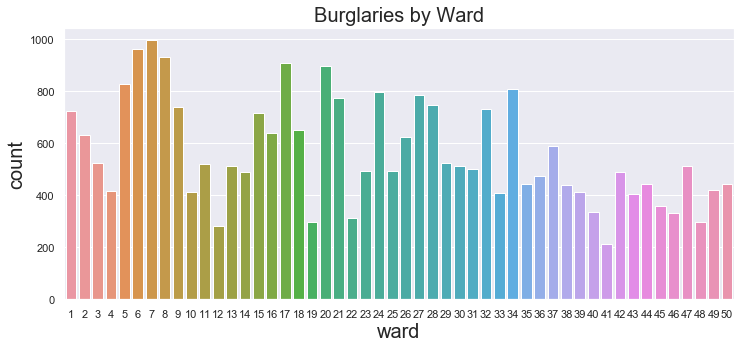

In [61]:
ax = sns.countplot(x="ward", data=burglary)
plt.title("Burglaries by Ward")
plt.show()

####  This is just a placeholder to associate these wards on the map, not the correct map yet. I am trying to make a similar map to show burglary statistics.  ![title](chicago_ward.jpg)

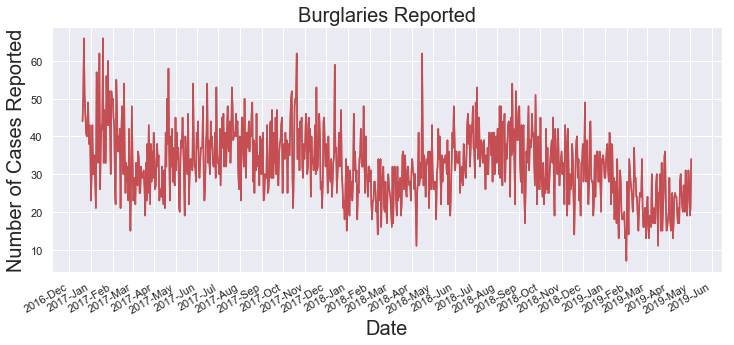

In [62]:
burglary_per_day = pd.DataFrame()
burglary_per_day =  burglary[['date', 'case_number']]
burglary_per_day = burglary_per_day.set_index(pd.to_datetime(burglary_per_day['date']))
burglary_per_day = burglary_per_day.resample('D').count()
plt.rcParams['figure.figsize'] = 12,5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(burglary_per_day.index, burglary_per_day, 'r-')
plt.xlabel('Date')
plt.ylabel('Number of Cases Reported')
plt.title('Burglaries Reported')
plt.show()

In [63]:
'''
import plotly.plotly as py
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

aggs = ["count"]
agg = []
agg_func = []
for i in range(0, len(aggs)):
    agg = dict(
        args=['transforms[0].aggregations[0].func', aggs[i]],
        label=aggs[i],
        method='restyle'
    )
    agg_func.append(agg)


colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['IL'],
    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Crimes by Ward', title='Chicago IL'
)
py.iplot(fig, filename='choropleth_crimes_by_ward_chicago')
'''

'\nimport plotly.plotly as py\nimport plotly.figure_factory as ff\nimport numpy as np\nimport pandas as pd\n\naggs = ["count"]\nagg = []\nagg_func = []\nfor i in range(0, len(aggs)):\n    agg = dict(\n        args=[\'transforms[0].aggregations[0].func\', aggs[i]],\n        label=aggs[i],\n        method=\'restyle\'\n    )\n    agg_func.append(agg)\n\n\ncolorscale = [\n    \'rgb(193, 193, 193)\',\n    \'rgb(239,239,239)\',\n    \'rgb(195, 196, 222)\',\n    \'rgb(144,148,194)\',\n    \'rgb(101,104,168)\',\n    \'rgb(65, 53, 132)\'\n]\n\nfig = ff.create_choropleth(\n    fips=fips, values=values, scope=[\'IL\'],\n    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,\n    county_outline={\'color\': \'rgb(255,255,255)\', \'width\': 0.5}, round_legend_values=True,\n    legend_title=\'Crimes by Ward\', title=\'Chicago IL\'\n)\npy.iplot(fig, filename=\'choropleth_crimes_by_ward_chicago\')\n'

In [64]:
burglary['event_date'] = burglary['date']
burglary = burglary.set_index('event_date')
#burglary.sort_values(by='date', inplace=True)
burglary.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,location_description,location_state,location_zip,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
event_date,,,,,,,,,,,,,,,,,,,,,
2017-03-28 14:00:00,False,835,026XX W 79TH ST,JB147595,70,2017-03-28 14:00:00,UNLAWFUL ENTRY,8,False,5,...,OTHER,None,None,-87.790969,BURGLARY,2018-02-11T15:57:41.000,18,NaN,NaN,2017
2017-12-16 14:30:00,False,511,102XX S EBERHART AVE,JB148941,49,2017-12-16 14:30:00,FORCIBLE ENTRY,5,False,5,...,VACANT LOT/LAND,None,None,-87.790969,BURGLARY,2018-02-12T15:49:14.000,9,NaN,NaN,2017
2017-10-01 08:00:00,False,123,008XX S PLYMOUTH CT,JB161932,32,2017-10-01 08:00:00,UNLAWFUL ENTRY,1,False,5,...,APARTMENT,None,None,-87.790969,BURGLARY,2018-02-23T15:57:04.000,2,NaN,NaN,2017
2018-08-01 10:00:00,False,424,090XX S HOUSTON AVE,JC221893,46,2018-08-01 10:00:00,FORCIBLE ENTRY,4,False,5,...,APARTMENT,None,None,-87.790969,BURGLARY,2019-04-13T16:01:56.000,10,NaN,NaN,2018
2017-01-12 12:00:00,False,513,107XX S CHAMPLAIN AVE,JA113654,50,2017-01-12 12:00:00,FORCIBLE ENTRY,5,False,5,...,RESIDENCE,,,-87.607332,BURGLARY,2018-02-10T15:50:01.000,9,1182514.0,1833773.0,2017


In [65]:
burglary = burglary[['date', 'latitude', 'longitude']]


## Business License
Data from business licenses. This will help us looking into licensing situation of the business whether there is tobaco/alcohol liscences or how that is related to the inspection failure. or may help answer if the businesses are more cleaner when they are close to duedate for license renewal?  

In [66]:
#business = pd.read_csv('../data/raw/Business_Licenses.csv', parse_dates=['LICENSE TERM START DATE'])
#business.head(2)
#business.info()
#date_window = pd.to_datetime('05/01/2016')
#business = business[business['LICENSE TERM START DATE'] > date_window]
#business.to_csv("../data/processed/business_license_termstart_gt_2016-05-01.csv")

In [67]:
date_cols =  ['APPLICATION CREATED DATE', 'LICENSE STATUS CHANGE DATE', 'PAYMENT DATE', 'LICENSE TERM START DATE','LICENSE TERM EXPIRATION DATE' , 'DATE ISSUED']
business = pd.read_csv('../data/processed/business_license_termstart_gt_2016-05-01.csv', parse_dates=date_cols)

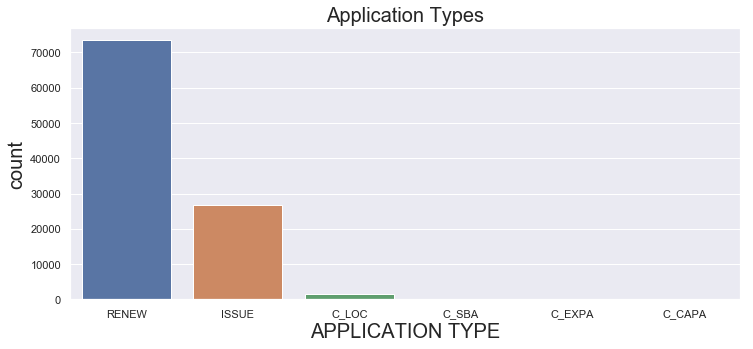

In [68]:
ax = sns.countplot(x="APPLICATION TYPE", data=business)
plt.title("Application Types")
plt.show()

APPLICATION TYPE: ‘ISSUE’ is the record associated with the initial license application. ‘RENEW’ is a subsequent renewal record. All renewal records are created with a term start date and term expiration date. ‘C_LOC’ is a change of location record. It means the business moved. ‘C_CAPA’ is a change of capacity record. Only a few license types may file this type of application. ‘C_EXPA’ only applies to businesses that have liquor licenses. It means the business location expanded.


LICENSE STATUS: ‘AAI’ means the license was issued. ‘AAC’ means the license was cancelled during its term.‘REV’means the license was revoked. ‘REA’means the license revocation has been appealed.

LICENSE STATUS CHANGE DATE: This date corresponds to the date a license was cancelled (AAC), revoked (REV) or appealed (REA).

In [69]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102062 entries, 0 to 102061
Data columns (total 35 columns):
Unnamed: 0                           102062 non-null int64
ID                                   102062 non-null object
LICENSE ID                           102062 non-null int64
ACCOUNT NUMBER                       102062 non-null int64
SITE NUMBER                          102062 non-null int64
LEGAL NAME                           102061 non-null object
DOING BUSINESS AS NAME               102011 non-null object
ADDRESS                              102062 non-null object
CITY                                 102060 non-null object
STATE                                102061 non-null object
ZIP CODE                             101899 non-null object
WARD                                 93601 non-null float64
PRECINCT                             83338 non-null float64
WARD PRECINCT                        93606 non-null object
POLICE DISTRICT                      83973 non-null fl

In [70]:
columns_to_take = ['LICENSE DESCRIPTION', 'ID', 'BUSINESS ACTIVITY ID', 'LICENSE CODE', 'LICENSE NUMBER', 'CONDITIONAL APPROVAL', 'APPLICATION TYPE', 'LICENSE TERM EXPIRATION DATE', 'LICENSE TERM START DATE', 'APPLICATION REQUIREMENTS COMPLETE','CONDITIONAL APPROVAL', 'BUSINESS ACTIVITY', 'DATE ISSUED', 'LICENSE STATUS CHANGE DATE' ]
business = business[columns_to_take]
column_dict = {}
for column in columns_to_take:
    column_dict[column] = column.lower().replace(' ', '_')
business.rename(columns= column_dict, inplace=True)

business['license_number'] = business['license_number'].astype(int)
cond_approval = {"conditional_approval" : {"N" : 0, "Y" : 1}}
business.replace(cond_approval, inplace=True)

In [71]:
inspected_matched_license = business[business.application_type=="ISSUE"]
inspected_matched_license = inspected_matched_license[(inspected_matched_license['license_term_start_date']-pd.Timedelta(730)) < inspected_matched_license['license_term_expiration_date']]
inspected_matched_license = inspected_matched_license.loc[:,~inspected_matched_license.columns.duplicated()]

In [72]:
inspected_matched_license.shape

(26491, 13)

In [73]:
food_data.shape

(14312, 25)

In [74]:
food_business_match = pd.merge(left=food_data, right=inspected_matched_license, left_on='license', right_on='license_number')
food_business_match.sort_values('inspection_date', inplace=True)

In [75]:
food_business_match.shape

(1971, 38)

In [76]:
food_business_match.head()

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,...,license_code,license_number,conditional_approval,application_type,license_term_expiration_date,license_term_start_date,application_requirements_complete,business_activity,date_issued,license_status_change_date
0,505 N MICHIGAN AVE,"ENO, EMPL CAFE, BANQUET",INTERCONTINENTAL HOTEL CHICAGO,Restaurant,2017-01-04,1978876,Canvass,41.891121,2437408,-87.623989,...,1006,2437408,0,ISSUE,2018-04-15,2016-05-17,02/11/2016,Sale of Food Prepared Onsite With Dining Area ...,2016-05-17,NaT
3,505 N MICHIGAN AVE,MICHAEL JORDAN'S STEAKHOUSE,INTERCONTINENTAL HOTEL CHICAGO,Restaurant,2017-01-04,1978879,Canvass,41.891121,2437403,-87.623989,...,1006,2437403,0,ISSUE,2018-04-15,2016-05-17,02/11/2016,Preparation of Food and Dining on Premise With...,2016-05-17,NaT
6,2100 W ROSCOE ST,VICTORY'S BANNER,VICTORY'S BANNER,Restaurant,2017-01-04,1978857,Canvass,41.943296,2476471,-87.680941,...,1006,2476471,0,ISSUE,2018-08-15,2016-08-01,07/18/2016,Sale of Food Prepared Onsite With Dining Area,2016-08-01,NaT
9,1708 W LAWRENCE AVE,TAQUERIA PRIMO CHUKIS UPTOWN,TAQUERIA PRIMO CHUKIS UPTOWN,Restaurant,2017-01-04,1978913,Canvass,41.968967,2483425,-87.671435,...,1006,2483425,0,ISSUE,2018-09-15,2016-09-08,08/23/2016,Preparation of Food and Dining on Premise With...,2016-09-08,NaT
11,505 N MICHIGAN AVE,STARBUCKS,INTERCONTINENTAL HOTEL CHICAGO,Restaurant,2017-01-04,1978880,Canvass,41.891121,2437970,-87.623989,...,1006,2437970,0,ISSUE,2018-04-15,2016-05-26,02/11/2016,Sale of Food Prepared Onsite With Dining Area ...,2016-04-06,NaT


In [77]:
food_business_match['HasTobaccoLicense'] = food_business_match['license_description'].apply( lambda x: 1 if 'Tobacco' in x else 0)
food_business_match['HasAlcoholLicense'] = food_business_match['license_description'].apply( lambda x: 1 if 'Consumption on Premises - Incidental Activity' in x else 0)

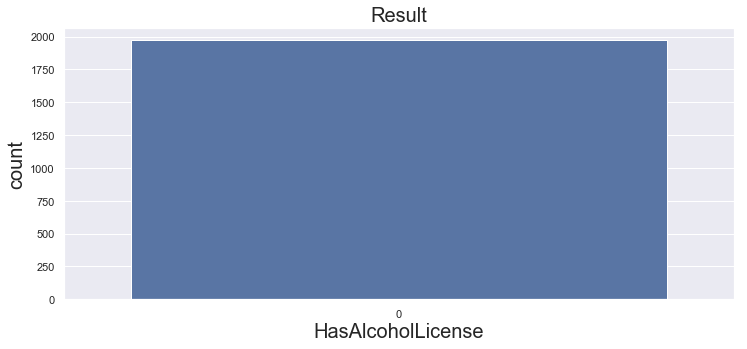

In [78]:
ax=sns.countplot(x="HasAlcoholLicense", data=food_business_match)
plt.title("Result")
plt.show()

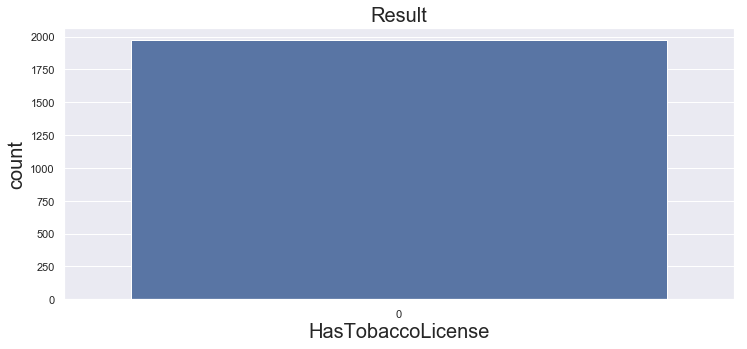

In [79]:
ax = sns.countplot(x="HasTobaccoLicense", data=food_business_match)
plt.title("Result")
plt.show()

In [80]:
#food_business['HasTobaccoLicense'] = food_business.apply(lambda x : 1 if (x['license_code'] == 1780) or (x['license_code'] == 1787) else 0, axis=1)
#food_business['HasAlcoholLicense'] = food_business.apply(lambda x : 1 if (x['license_code'] == 1481) | (x['license_code'] == 1475) | (x['license_code'] == 1474) | (x['license_code'] == 1470) else 0 , axis = 1)

In [81]:
#food_business.business_activity_id.value_counts()

Now I want to merge the inspection and business data frames. we can do inner join on license number from inspection data and License ID from business data.

In [82]:
food_business = food_data.copy(deep=True)

In [83]:
#food_business = food_business[food_business['inspection_date'] > pd.to_datetime('2018-07-01')]

## Garbage and Sanitation From (311 complaints)
Is there trash/garbage/sanitation/rodents etc complaints in the neighborhood or how that affects the outcome of the inspection. 

In [84]:
garbage_prior_july18 = pd.read_json('../data/raw/garbagedata_prior_to_july2018.json', convert_dates=['completion_date', 'creation_date'])
sanitation_prior_july18 = pd.read_json('../data/raw/sanitation_prior_to_july2018.json', convert_dates=['completion_date', 'creation_date'])
rodent_prior_july18 = pd.read_json('../data/raw/rodent_prior_to_july2018.json', convert_dates=['completion_date', 'creation_date'])

In [85]:
service_prior_july18 = pd.concat([garbage_prior_july18,sanitation_prior_july18, rodent_prior_july18 ], ignore_index=True)

In [86]:
service_prior_july18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174027 entries, 0 to 174026
Data columns (total 23 columns):
community_area                                174026 non-null float64
completion_date                               173932 non-null datetime64[ns]
creation_date                                 174027 non-null datetime64[ns]
current_activity                              124731 non-null object
latitude                                      174001 non-null float64
location                                      174001 non-null object
longitude                                     174001 non-null float64
most_recent_action                            124624 non-null object
number_of_black_carts_delivered               60206 non-null float64
number_of_premises_baited                     64818 non-null float64
number_of_premises_with_garbage               64889 non-null float64
number_of_premises_with_rats                  64961 non-null float64
police_district                           

In [87]:
service_prior_july18 = service_prior_july18[['creation_date', 'latitude', 'longitude', 'completion_date', 'type_of_service_request']]
service_prior_july18.sort_values('creation_date', inplace=True)
service_prior_july18.rename(columns={'creation_date':'created_date', 'completion_date':'closed_date', 'type_of_service_request' : 'sr_type' }, inplace=True)

In [88]:
service_prior_july18.head()

,created_date,latitude,longitude,closed_date,sr_type
87130,2016-12-21,41.917528,-87.692695,2016-12-27,Sanitation Code Violation
56011,2016-12-21,41.933785,-87.768615,2017-02-23,Garbage Cart Black Maintenance/Replacement
169381,2016-12-21,41.763938,-87.700351,2016-12-21,Rodent Baiting/Rat Complaint
158797,2016-12-21,41.898193,-87.726169,2016-12-21,Rodent Baiting/Rat Complaint
142703,2016-12-21,41.802214,-87.662370,2016-12-21,Rodent Baiting/Rat Complaint


In [89]:
service_data = pd.read_json('../data/raw/servicedata.json', convert_dates=['closed_date', 'created_date', 'last_modified_date'])
service_data.head(3)

,city,closed_date,community_area,created_date,created_day_of_week,created_hour,created_month,duplicate,electrical_district,electricity_grid,...,status,street_address,street_direction,street_name,street_number,street_type,ward,x_coordinate,y_coordinate,zip_code
0,None,NaT,NaN,2019-03-13 14:10:42,4,14,3,False,NaN,None,...,Open,1510 S Lincoln ST,S,Lincoln,1510,ST,NaN,NaN,NaN,60064
1,None,2019-03-27 12:46:21,NaN,2019-03-26 14:14:39,3,14,3,False,NaN,None,...,Completed,10423 S king drive AVE,S,king drive,10423,AVE,NaN,NaN,NaN,60628
10,None,NaT,21.0,2019-04-13 10:02:18,7,10,4,False,NaN,None,...,Open,3743 N Avers,N,Avers,3743,None,30.0,1.150186e+06,1.921563e+06,None


In [90]:
service_data['sr_type'].value_counts()

Garbage Cart Maintenance             40753
Rodent Baiting/Rat Complaint         34926
Sanitation Code Violation            13216
Sewer Cleaning Inspection Request    11791
Name: sr_type, dtype: int64

In [91]:
service_data['sr_short_code'].value_counts()

SIE         40753
SGA         34926
SCB         13216
CHECKFOR    11791
Name: sr_short_code, dtype: int64

In [92]:
service_data = service_data[service_data['sr_short_code'] != 'CHECKFOR']

In [93]:
service_data = service_data[['created_date', 'latitude', 'longitude', 'closed_date', 'sr_type', 'duplicate']]

In [94]:
service_data = pd.concat([service_data, service_prior_july18], ignore_index=True)

In [95]:
shape = service_data.shape
sr_type_map = {"sr_type" : {"Garbage Cart Black Maintenance/Replacement" : "Garbage Cart Maintenance"}}
service_data.replace(sr_type_map, inplace=True)
print(" So there are %d rows and %d columns in the data" % (shape[0], shape[1]))
#service_data['created_date'] = service_data['created_date'].dt.date

 So there are 262922 rows and 6 columns in the data


In [96]:
service_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262922 entries, 0 to 262921
Data columns (total 6 columns):
closed_date     260775 non-null datetime64[ns]
created_date    262922 non-null datetime64[ns]
duplicate       88895 non-null object
latitude        262627 non-null float64
longitude       262627 non-null float64
sr_type         262922 non-null object
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 12.0+ MB


I now want to count number of these incidents around the business and within some prespecified time. We can optimize the distance and the time windows but for the first pass study I am just foucsing on within 5 miles radii and the 7 days before the inspection date. 

In [97]:
print("Latitude NA values = %s" %service_data.latitude.isna().sum())
print("Longitude NA values = %s" %service_data.longitude.isna().sum())

Latitude NA values = 295
Longitude NA values = 295


In [98]:
service_data['latitude'].fillna(service_data['latitude'].mode()[0], inplace=True)
service_data['longitude'].fillna(service_data['longitude'].mode()[0], inplace=True)

In [99]:
#service_data['event_date'] = service_data['created_date']

In [100]:
service_data.sr_type.value_counts()

Garbage Cart Maintenance        117935
Rodent Baiting/Rat Complaint    102424
Sanitation Code Violation        42563
Name: sr_type, dtype: int64

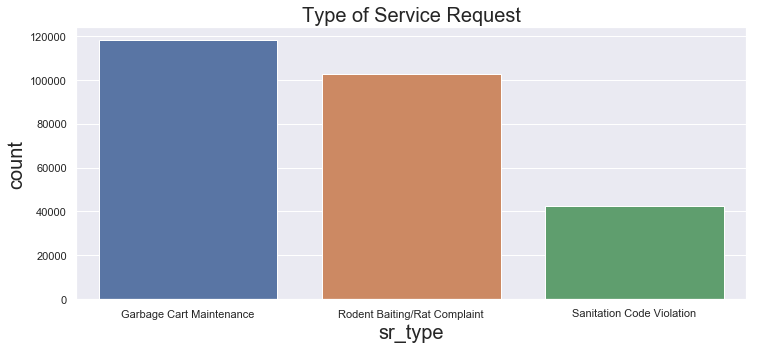

In [101]:
ax = sns.countplot(x='sr_type', data=service_data)
plt.title("Type of Service Request")
plt.show()

In [102]:
service_data["sr_type"] = service_data["sr_type"].astype('category').cat.codes

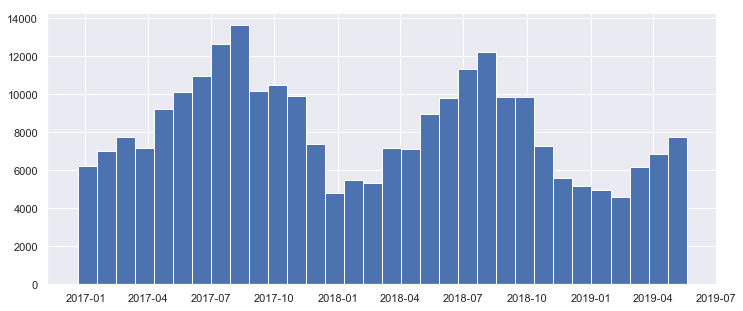

In [103]:
service_data['created_date'].hist(bins = 32)

In [104]:
service_data.sort_values(by='created_date', inplace=True)
service_data = service_data[['created_date','latitude', 'longitude']]

In [105]:
from pandarallel import pandarallel
pandarallel.initialize()

def get_distance(a_lat, a_lng, b_lat, b_lng):
    R = 3956  # earth radius in miles
    a_lat = np.radians(a_lat)
    a_lng = np.radians(a_lng)
    b_lat = np.radians(b_lat)
    b_lng = np.radians(b_lng)
    d_lat = b_lat - a_lat
    d_lng = b_lng - a_lng

    d_lat_sq = np.sin(d_lat / 2) ** 2
    d_lng_sq = np.sin(d_lng / 2) ** 2

    a = d_lat_sq + np.cos(a_lat) * np.cos(b_lat) * d_lng_sq
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return R * c  # returns distance between a and b in mile

def count_burglaries(row):
    df = burglary.copy(deep=True)
    time_window=30
    distance_window=0.25
    df = df[(df['date'] > (row['inspection_date'] - pd.Timedelta(days=time_window))) & (df['date'] < (row['inspection_date']))]
    #df['d_time'] = (row['inspection_date'] - df['date']).dt.days
    #df = df[(df['d_time'] < 0) & (df['d_time'] >= -time_window)]
    df['distance'] = get_distance(row['latitude'], row['longitude'], df['latitude'].values, df['longitude'].values)
    dfNew = df[df['distance'] < distance_window]
    return dfNew.shape[0]

def count_sanitation_complaints(row):
    df = service_data.copy(deep=True)
    time_window=30
    distance_window=0.25
    #df['d_time'] = (row['inspection_date'] - df['created_date']).dt.days
    #df = df[(df['d_time'] < 0) & (df['d_time'] >= -time_window)]
    df = df[(df['created_date'] > (row['inspection_date'] - pd.Timedelta(days=time_window))) & (df['created_date'] < (row['inspection_date']))]
    df['distance'] = get_distance(row['latitude'], row['longitude'], df['latitude'].values, df['longitude'].values)
    dfNew = df[df['distance'] < distance_window]
    
    return dfNew.shape[0]
    #complaints = dfNew['sr_short_code'].value_counts()
    #comp_dict = {"sewer": complaints[0] , "sanitation": complaints[1], "rodent": complaints[2], "garbage": complaints[3]}
    #return comp_dict

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 4 workers


In [106]:
%timeit food_business['burglaries_last_month'] = food_business.parallel_apply(count_burglaries, axis=1)

11min 57s ± 1.67 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
%timeit food_business['service_complains_last_month'] = food_business.parallel_apply(count_sanitation_complaints, axis=1)

12min 13s ± 1.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
food_business.shape
#food_business['license'].nunique()

(14312, 27)

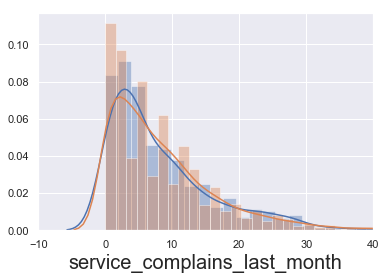

In [42]:
pass_ins = food_business[food_business['CriticalFound'] == 1]
fail_ins = food_business[food_business['CriticalFound'] == 0]
plt.xlim(-10, 40)
sns.distplot(pass_ins['service_complains_last_month'],hist=True, label = 'pass')
sns.distplot(fail_ins['service_complains_last_month'],hist=True, label = 'fail')
plt.show()

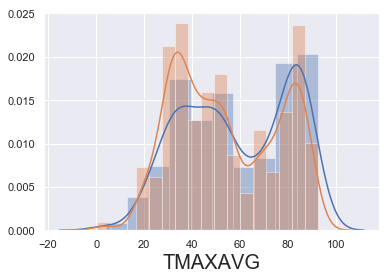

In [43]:
sns.distplot(pass_ins['TMAXAVG'],hist=True, label = 'pass')
sns.distplot(fail_ins['TMAXAVG'],hist=True, label = 'fail')
plt.show()

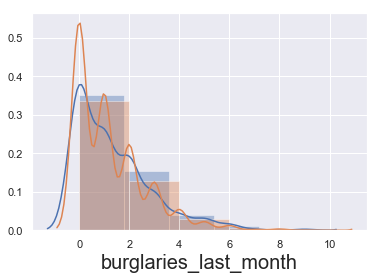

In [44]:
sns.distplot(pass_ins['burglaries_last_month'], bins=5, label = 'pass')
sns.distplot(fail_ins['burglaries_last_month'], bins=5, label = 'fail')
plt.show()

In [45]:
# write t_test function
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)

In [46]:
# run the t-test at a 5% sig level
test = t_test(pass_ins['service_complains_last_month'], fail_ins['service_complains_last_month'], 0.05)
print(test)

DegFreedom    1094.761142
Difference      -0.368742
Statistic       -1.101542
PValue           0.270903
Low95CI         -1.025567
High95CI         0.288084
dtype: float64


In [47]:
test = t_test(pass_ins['TMAXAVG'], fail_ins['TMAXAVG'], 0.05)
print(test)

DegFreedom    1.000197e+03
Difference    4.570509e+00
Statistic     4.930567e+00
PValue        9.594764e-07
Low95CI       2.751472e+00
High95CI      6.389547e+00
dtype: float64


In [48]:
test = t_test(pass_ins['burglaries_last_month'], fail_ins['burglaries_last_month'], 0.05)
print(test)

DegFreedom    973.924087
Difference      0.128170
Statistic       2.041260
PValue          0.041494
Low95CI         0.004951
High95CI        0.251388
dtype: float64


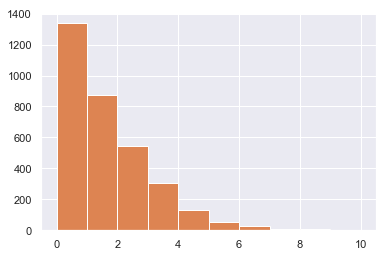

In [49]:
pass_ins['burglaries_last_month'].hist(bins=10)
fail_ins['burglaries_last_month'].hist(bins=10)

In [50]:
# run the t-test at a 5% sig level
test = t_test(pass_ins['burglaries_last_month'], fail_ins['burglaries_last_month'], 0.05)
print(test)

DegFreedom    973.924087
Difference      0.128170
Statistic       2.041260
PValue          0.041494
Low95CI         0.004951
High95CI        0.251388
dtype: float64


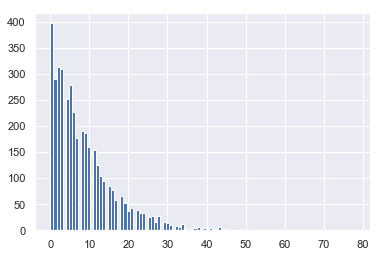

In [51]:
foood_business= food_business.set_index('inspection_date')
food_business['service_complains_last_month'].hist(bins=100)

#### I also want to use Yelp's rating and comments ( for some sort of sentiment analysis if possible) in my model. So let's see if that is feasible. To start with, I am focusing only on the restaurants (category) that failed in the inspection. Also note taht yelp caps 5000 API calls per per day so I chose to focus on failed restaurants only. 
### Let's write some functions to use Yelp API. 

In [52]:
# yelp authorization ( Need to hide this ! )
#res_fail = fail_inspection[fail_inspection['facility_type_cat'] == 2]
import requests
api_key='skulWTrlVslLqkj5vY7u9fJErIOi-FB1prbAhB4ftwLLBSN5CarHecqiOPET6gVDOUhiEfvMD5O8tn--Evkbdn0MujX5Lncp5TNPNw_rzT_pAHtW0qIBC0pPgcqrXHYx' 
headers = {'Authorization': 'Bearer %s' % api_key,}

# find business match using business name (aka_name dba(doing business as name) 
def get_business_match(row):
    
    params = {}
    params["name"] = row['aka_name'] 
    params["address1"] = row['address']
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'
    
    request = requests.get("https://api.yelp.com/v3/businesses/matches",headers=headers,params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        return data['businesses'][0]['id']
    except:
        return 0
    
    ## pull ratings and reviews of the matched businesses.

def get_reviews(business_id):
    query = "https://api.yelp.com/v3/businesses/%s/reviews" %business_id
    try:
        request = requests.get(query, headers=headers)
        data = request.json()
        return data
    except:
        ValueError("This business doesn't have any reviews")
        
def get_rating(business_id):
    try:
        query = "https://api.yelp.com/v3/businesses/%s" %business_id
        request = requests.get(query, headers=headers)
        data = request.json()
        return data["rating"]
    except:
        return 9999
    
def get_yelp_data(row):
    params = {}
    params["name"] = row['aka_name']
    params["address1"] = row['address']
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'
    yelp_data = []
    request = requests.get("https://api.yelp.com/v3/businesses/matches",headers=headers,params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        business_id = data['businesses'][0]['id']
        rating =  get_rating(business_id)
        #reviews = get_reviews(business_id)
        yelp_data = (busines_id, rating)
        return yelp_data
    except:
        return 9999

In [53]:
#food_data['yelp_id'] = food_data.apply(lambda x: get_business_match(x['aka_name'], x['address']), axis=1)
#food_data['yelp_rating'] = food_data.apply(lambda x: get_rating(x["yelp_id"]), axis=1)

### Let's pull the information from the failed restaurants. 
#food_business['yelp_data'] = food_business.apply(lambda x: get_yelp_data(x['aka_name'], x['address']), axis=1)

That is encouraging! Looks like we can factor in those yelp ratings in our model. The mean rating has a peak at 4 even for failed restaurants but there is also a significant tail at the lower end of the spectrum. I may end of using it but I will have to set up a cronjob to make daily api calls for all these businesses.

In [2]:
#food_business.to_csv('../data/processed/food_business_data_processed.csv')
food_business = pd.read_csv('../data/processed/food_business_data_processed.csv', parse_dates = ['inspection_date'])
food_business['ins_date'] = food_business['inspection_date']
food_business['bus_license'] = food_business['license']
food_business = food_business.set_index(['bus_license', 'ins_date'])
food_business.sort_values(by = ['license', 'inspection_date'], ascending= [True, False], inplace=True)

In [3]:
'''
food_business['failed'] = food_business['results'].apply(lambda x: 1 if x==0  else 0 )
food_business['past_fail'] = food_business.groupby('license')['failed'].shift(-1).fillna(0)
food_business['past_critical_violations'] = food_business.groupby('license')['critical_violations'].shift(-1).fillna(0)
food_business['past_serious_violations'] = food_business.groupby('license')['serious_violations'].shift(-1).fillna(0)
food_business['past_minor_violations'] = food_business.groupby('license')['minor_violations'].shift(-1).fillna(0)
food_business['time_since_last_inspection'] = food_business.groupby('license')['inspection_date'].diff().dt.days.fillna(0).shift(-1)/365.0
food_business['time_since_last_inspection'].fillna(2, inplace=True)
food_business['time_since_last_inspection'] = food_business['time_since_last_inspection'].apply(lambda x: min(x, 2))
'''

"\nfood_business['failed'] = food_business['results'].apply(lambda x: 1 if x==0  else 0 )\nfood_business['past_fail'] = food_business.groupby('license')['failed'].shift(-1).fillna(0)\nfood_business['past_critical_violations'] = food_business.groupby('license')['critical_violations'].shift(-1).fillna(0)\nfood_business['past_serious_violations'] = food_business.groupby('license')['serious_violations'].shift(-1).fillna(0)\nfood_business['past_minor_violations'] = food_business.groupby('license')['minor_violations'].shift(-1).fillna(0)\nfood_business['time_since_last_inspection'] = food_business.groupby('license')['inspection_date'].diff().dt.days.fillna(0).shift(-1)/365.0\nfood_business['time_since_last_inspection'].fillna(2, inplace=True)\nfood_business['time_since_last_inspection'] = food_business['time_since_last_inspection'].apply(lambda x: min(x, 2))\n"

In [4]:
food_business['failed'] = food_business['results'].apply(lambda x: 1 if x==0  else 0 )
food_business['past_fail'] = food_business['failed'].shift(-1).fillna(0)
food_business['past_critical_violations'] = food_business['critical_violations'].shift(-1).fillna(0)
food_business['past_serious_violations'] = food_business['serious_violations'].shift(-1).fillna(0)
food_business['past_minor_violations'] = food_business['minor_violations'].shift(-1).fillna(0)
food_business['time_since_last_inspection'] = food_business['inspection_date'].diff().dt.days.fillna(0).shift(-1)/365.0
food_business['time_since_last_inspection'].fillna(2, inplace=True)
food_business['time_since_last_inspection'] = food_business['time_since_last_inspection'].apply(lambda x: min(x, 2))
food_business = food_business.reset_index()

In [5]:
#food_business.to_csv('../data/processed/data_processed_time_shifted.csv')
#food_business = pd.read_csv('../data/processed/data_processed_time_shifted.csv', parse_dates = ['inspection_date'])
#food_business['time_since_last_inspection'] = food_business['time_since_last_inspection']

In [6]:
#food_business[['critical_violations', 'past_critical_violations','results', 'minor_violations', 'past_minor_violations', 'time_since_last_inspection']]

In [7]:
food_business = food_business[(food_business['facility_type'] == 'Restaurant') | (food_business['facility_type'] == 'Grocery Store')]
food_business = food_business[food_business['inspection_date'] > pd.to_datetime('2018-07-01')]

In [8]:
#food_business['yelp_id'] = food_business.apply(lambda x: get_business_match(x), axis=1)
#food_business['yelp_rating'] = food_business['yelp_id'].apply(lambda x: get_rating(x))
#food_business.to_csv('../data/processed/data_processed_with_yelp_rating.csv')

In [9]:
#food_business = pd.read_csv('../data/processed/data_processed_with_yelp_rating.csv', parse_dates = ['inspection_date'])
#food_business = food_business[food_business["yelp_rating"] < 6]

In [10]:
#food_business[food_business["yelp_rating"] < 6]['yelp_rating'].hist()

In [11]:
#food_business.set_index('inspection_date')
INSPECT_WINDOW = food_business['inspection_date'].max() - (pd.Timedelta(days=45))
print(INSPECT_WINDOW)
food_business_sample = food_business[(food_business['inspection_date'] < INSPECT_WINDOW)]
#food_business_test_sample = food_business[(food_business['inspection_date'] >= pd.to_datetime('2019-02-15')) & (food_business['inspection_date'] < pd.to_datetime('2019-03-01')) ]
food_business_test_sample = food_business[(food_business['inspection_date'] >= INSPECT_WINDOW)]

2019-03-25 00:00:00


In [12]:
features = ["past_minor_violations", "past_serious_violations", "past_critical_violations", "burglaries_last_month", "service_complains_last_month", 'time_since_last_inspection', 'TMAXAVG']
print(features)

['past_minor_violations', 'past_serious_violations', 'past_critical_violations', 'burglaries_last_month', 'service_complains_last_month', 'time_since_last_inspection', 'TMAXAVG']


Now that we have some features we can start building some baseline models:

In [13]:
'''
# Down sampling
n_with_critical_violations = food_business_sample.CriticalFound.value_counts()[1]

print(n_with_critical_violations)

#randomly selecting 'n' samples from restaurants without violations
no_violation = food_business_sample[food_business_sample['CriticalFound'] == 0]
with_violation = food_business_sample[food_business_sample['CriticalFound'] == 1]

selected = no_violation.sample(n_with_critical_violations, random_state=101)
#selected.head()
#concatenating both into a subsample data set with equal class distribution
selected.reset_index(drop=True, inplace=True)
with_violation.reset_index(drop=True, inplace=True)
food_business_subsample = pd.concat([selected, with_violation])
#shuffling our data set
food_business_subsample = food_business_subsample.sample(frac=1).reset_index(drop=True)
#subsample.head(10)
'''

"\n# Down sampling\nn_with_critical_violations = food_business_sample.CriticalFound.value_counts()[1]\n\nprint(n_with_critical_violations)\n\n#randomly selecting 'n' samples from restaurants without violations\nno_violation = food_business_sample[food_business_sample['CriticalFound'] == 0]\nwith_violation = food_business_sample[food_business_sample['CriticalFound'] == 1]\n\nselected = no_violation.sample(n_with_critical_violations, random_state=101)\n#selected.head()\n#concatenating both into a subsample data set with equal class distribution\nselected.reset_index(drop=True, inplace=True)\nwith_violation.reset_index(drop=True, inplace=True)\nfood_business_subsample = pd.concat([selected, with_violation])\n#shuffling our data set\nfood_business_subsample = food_business_subsample.sample(frac=1).reset_index(drop=True)\n#subsample.head(10)\n"

In [14]:
from imblearn.over_sampling import SMOTE
X = food_business_sample[features]
Y = food_business_sample['CriticalFound']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=103)

smote = SMOTE(ratio='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)

In [15]:

#Y_data = pd.DataFrame(data=Y_smote, columns = ['CriticalFound'])
#X_data.reset_index()
#Y_data.reset_index()
#Y_data = Y_data.values.reshape(-1,)

'''
X_train = pd.DataFrame(data=X_train, columns=features)
Y_train = pd.DataFrame(data=Y_train, columns = ['CriticalFound'])
X_test = pd.DataFrame(data=X_test, columns=features)
Y_test = pd.DataFrame(data=Y_test, columns = ['CriticalFound'])
X_train = X_train.reset_index()
Y_train = Y_train.reset_index()
X_test = X_test.reset_index()
Y_test = Y_test.reset_index()

X = food_business_sample[features]
Y = food_business_sample['CriticalFound']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=103)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Before Scaling')
sns.distplot(X['service_complains_last_month'], ax=ax1)
sns.distplot(X['burglaries_last_month'], ax=ax1)
sns.distplot(X['past_serious_violations'], ax=ax1)
sns.distplot(X['past_critical_violations'], ax=ax1)
plt.show()

X['service_complains_last_month'] = (X['service_complains_last_month'] - X['service_complains_last_month'].mean())/X['service_complains_last_month'].std()
X['burglaries_last_month'] = (X['burglaries_last_month']-X['burglaries_last_month'].mean())/X['burglaries_last_month'].std()                                     
X['past_serious_violations'] = (X['past_serious_violations'] - X['past_serious_violations'].mean())/X['past_serious_violations'].std()
X['past_critical_violations'] = (X['past_critical_violations']-X['past_critical_violations'].mean())/X['past_critical_violations'].std()                                     
X['past_minor_violations'] = (X['past_minor_violations']-X['past_minor_violations'].mean())/X['past_minor_violations'].std()                                     

ax2.set_title('After Standard Scaler')
sns.distplot(X['service_complains_last_month'], ax=ax2)
#sns.distplot(X['burglaries_last_month'], ax=ax2)
#sns.distplot(X['past_serious_violations'], ax=ax2)
#sns.distplot(X['past_critical_violations'], ax=ax2)

'''

"\nX_train = pd.DataFrame(data=X_train, columns=features)\nY_train = pd.DataFrame(data=Y_train, columns = ['CriticalFound'])\nX_test = pd.DataFrame(data=X_test, columns=features)\nY_test = pd.DataFrame(data=Y_test, columns = ['CriticalFound'])\nX_train = X_train.reset_index()\nY_train = Y_train.reset_index()\nX_test = X_test.reset_index()\nY_test = Y_test.reset_index()\n\nX = food_business_sample[features]\nY = food_business_sample['CriticalFound']\nX_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=103)\n\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))\nax1.set_title('Before Scaling')\nsns.distplot(X['service_complains_last_month'], ax=ax1)\nsns.distplot(X['burglaries_last_month'], ax=ax1)\nsns.distplot(X['past_serious_violations'], ax=ax1)\nsns.distplot(X['past_critical_violations'], ax=ax1)\nplt.show()\n\nX['service_complains_last_month'] = (X['service_complains_last_month'] - X['service_complains_last_month'].mean())/X['service_complains

In [16]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
#print(X_valid.shape)
#print(Y_valid.shape)

(3816, 7)
(3816,)
(988, 7)
(988,)


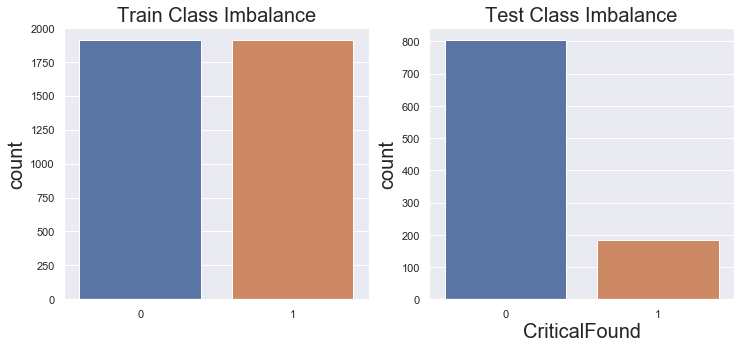

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Train Class Imbalance')
sns.countplot(x=Y_train, ax=ax1)

ax2.set_title('Test Class Imbalance')
sns.countplot(x=Y_test, ax=ax2)
plt.show()

We should note that there is class imbalance here and we should be careful about building our classfier. 

In [18]:
#Make sure that there are no n/a values in our data frame. 
print(X.isna().sum())

past_minor_violations           0
past_serious_violations         0
past_critical_violations        0
burglaries_last_month           0
service_complains_last_month    0
time_since_last_inspection      0
TMAXAVG                         0
dtype: int64


In [19]:
def modelfit(alg, X_train, Y_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, Y_train)
        
    #Predict training set:
    train_predictions = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, Y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(Y_train, train_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Y_train, train_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        importances = alg.feature_importances_
        indices = np.argsort(importances)[::-1]
        names = [features[i] for i in indices]
        feat_imp = pd.Series(alg.feature_importances_, names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

### Logistic Regression Model 

In [58]:
# train a logistic regression model on the training set
# instantiate model
logreg = LogisticRegression( random_state=101, fit_intercept=True, tol=0.01)
print(logreg)

#logreg.fit(X_train, Y_train)
# make class predictions for the testing set

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.01, verbose=0, warm_start=False)


In [59]:
param_grid = {
    'C': [0.5, 1, 1.5, 2.0, 2.5, 3.0, 4, 5, 10, 15],
    #'dual': [True, False],
    'max_iter': [100, 110, 120, 150, 200, 500, 700, 1000]
}
lgr_rand_search = RandomizedSearchCV(estimator = logreg, param_distributions=param_grid, 
                         cv = 5, n_jobs = -1, random_state=101)

lgr_rand_search.fit(X_train, Y_train)
#Best estimator and CV score
print('Best Accuracy score ', lgr_rand_search.best_score_)
print(lgr_rand_search.best_estimator_)

logreg = lgr_rand_search.best_estimator_

Best Accuracy score  0.5469077568134172
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.01, verbose=0, warm_start=False)


In [60]:
# fit model
modelfit(logreg, X_train, Y_train, True, False, 5)


Model Report
Accuracy : 0.5553
AUC Score (Train): 0.585122
CV Score : Mean - 0.57638 | Std - 0.02069656 | Min - 0.559065 | Max - 0.6125449


[[ 0.02260726 -0.01872788  0.18598914 -0.00380804 -0.01749283  0.127223
   0.01058783]]
Accuracy = 0.5860323886639676 
Confusion Matrix 
[[486 317]
 [ 92  93]]
ROC-AUC = 0.5870956884655515 
F1-Score = 0.3126050420168068 
Recall-Score = 0.5027027027027027 


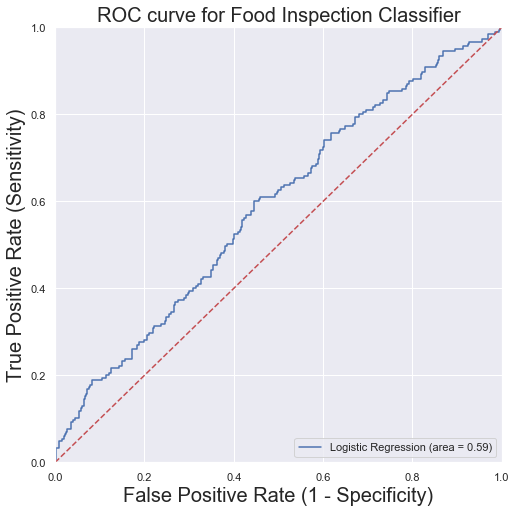

In [61]:
y_pred_class = logreg.predict(X_test)
print(logreg.coef_)
# calculate accuracy
print("Accuracy = %s " %metrics.accuracy_score(Y_test, y_pred_class))
print("Confusion Matrix ")
print(metrics.confusion_matrix(Y_test, y_pred_class))

y_pred_proba = logreg.predict_proba(X_test)[:,1]
print("ROC-AUC = %s " %metrics.roc_auc_score(Y_test, y_pred_proba))
print("F1-Score = %s " %metrics.f1_score(Y_test, y_pred_class))
print("Recall-Score = %s " %metrics.recall_score(Y_test, y_pred_class))

plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % metrics.roc_auc_score(Y_test, y_pred_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Food Inspection Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [62]:
print(metrics.classification_report(Y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.84      0.61      0.70       803
           1       0.23      0.50      0.31       185

   micro avg       0.59      0.59      0.59       988
   macro avg       0.53      0.55      0.51       988
weighted avg       0.73      0.59      0.63       988



## DecisionTree Classifier

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

Model Report
Accuracy : 0.9992
AUC Score (Train): 0.999999
CV Score : Mean - 0.7984143 | Std - 0.1028363 | Min - 0.5929319 | Max - 0.8543283
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=15, max_features=None, max_leaf_nodes=50,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')
Accuracy = 0.7439271255060729 
F1 Score = 0.20189274447949526 
ROC-AUC Score = 0.5459459459459459 
Recall-Score = 0.17297297297297298 


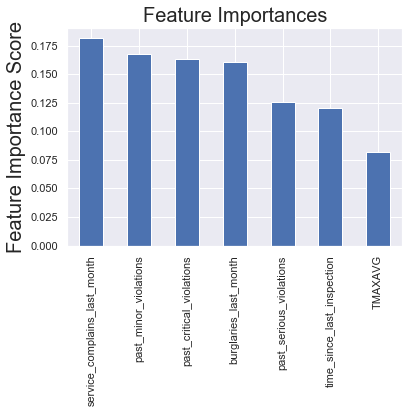

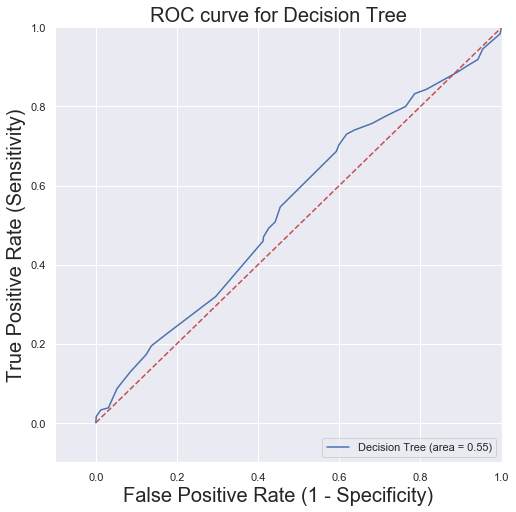

In [63]:
dt = DecisionTreeClassifier(random_state=101, class_weight='balanced', criterion = 'entropy')
print(dt)

modelfit(dt, X_train, Y_train, True, True, 5)

param_grid = {
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 50],
    'min_samples_split': [2, 2, 4, 6, 8],
    'max_depth': [1, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20]
}
dt_rand_search = RandomizedSearchCV(estimator = dt, param_distributions=param_grid, 
                         cv = 5, n_jobs = 2, random_state=101)


dt_rand_search.fit(X_train, Y_train)


#Best estimator and CV score
print(dt_rand_search.best_estimator_)

dt = dt_rand_search.best_estimator_

dt_y_pred_test = dt.predict(X_test)
dt_y_pred_test_proba = dt.predict_proba(X_test)[:, 1]
print("Accuracy = %s " % metrics.accuracy_score(Y_test, dt_y_pred_test))
print("F1 Score = %s " %metrics.f1_score(Y_test, dt_y_pred_test))
print("ROC-AUC Score = %s "%metrics.roc_auc_score(Y_test, dt_y_pred_test_proba))
print("Recall-Score = %s " %metrics.recall_score(Y_test, dt_y_pred_test))
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, dt_y_pred_test_proba)
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % metrics.roc_auc_score(Y_test, dt_y_pred_test_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Decision Tree')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Random Forest

In [64]:
'''
n_estimators = np.arange(1, 200, 4)
train_results = []
test_results = []
#class_weight = dict({0:1, 1:5})
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, random_state=101, n_jobs=-1)
   rf.fit(X_train, Y_train)
   train_pred_proba = rf.predict_proba(X_train)[:,1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred_proba)
   roc_auc_train = metrics.roc_auc_score(Y_train, train_pred_proba)
   train_results.append(roc_auc_train)
   y_pred_proba = rf.predict_proba(X_test)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred_proba)
   roc_auc_test = metrics.roc_auc_score(Y_test, y_pred_proba)
   test_results.append(roc_auc_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label= 'Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label= 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()
'''

'\nn_estimators = np.arange(1, 200, 4)\ntrain_results = []\ntest_results = []\n#class_weight = dict({0:1, 1:5})\nfor estimator in n_estimators:\n   rf = RandomForestClassifier(n_estimators=estimator, random_state=101, n_jobs=-1)\n   rf.fit(X_train, Y_train)\n   train_pred_proba = rf.predict_proba(X_train)[:,1]\n   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred_proba)\n   roc_auc_train = metrics.roc_auc_score(Y_train, train_pred_proba)\n   train_results.append(roc_auc_train)\n   y_pred_proba = rf.predict_proba(X_test)[:, 1]\n   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred_proba)\n   roc_auc_test = metrics.roc_auc_score(Y_test, y_pred_proba)\n   test_results.append(roc_auc_test)\nfrom matplotlib.legend_handler import HandlerLine2D\nline1, = plt.plot(n_estimators, train_results, \'b\', label= \'Train AUC\')\nline2, = plt.plot(n_estimators, test_results, \'r\', label= \'Test AUC\')\nplt.legend(handler_map={line1: Handle

In [73]:
rf = RandomForestClassifier(random_state=101, n_jobs=-1)
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)


In [74]:
param_grid = {
    'n_estimators': [4, 6, 8, 10, 15, 20, 25, 100],    
    'max_features': [1, 2, 3, 4, 5, 6, 7],
    'min_samples_split': [2, 2, 4, 6, 8],
    'max_depth': [1, 5, 10, 15, 20, 30, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20]
}
rf_rand_search = RandomizedSearchCV(estimator = rf, param_distributions=param_grid, 
                         cv = 5, n_jobs = -1, random_state=101)

rf_rand_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=101, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [4, 6, 8, 10, 15, 20, 25, 100], 'max_features': [1, 2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 2, 4, 6, 8], 'max_depth': [1, 5, 10, 15, 20, 30, 50], 'min_samples_leaf': [1, 2, 5, 10, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=101, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [75]:
clf = rf_rand_search.best_estimator_
#clf = RandomForestClassifier(n_estimators=12, random_state=101, n_jobs=-1)
clf = clf.fit(X_train, Y_train)
y_pred_rf = clf.predict(X_test)
# calculate accuracy
print("Accuracy = %s " %metrics.accuracy_score(Y_test, y_pred_rf))
print("F1-Score = %s " %metrics.f1_score(Y_test, y_pred_rf))
print("Recall-Score = %s " %metrics.recall_score(Y_test, y_pred_rf))
print("Confusion Matrix")
print(metrics.confusion_matrix(Y_test, y_pred_rf))

Accuracy = 0.770242914979757 
F1-Score = 0.13688212927756654 
Recall-Score = 0.0972972972972973 
Confusion Matrix
[[743  60]
 [167  18]]



Model Report
Accuracy : 0.9392
AUC Score (Train): 0.991800
CV Score : Mean - 0.9285205 | Std - 0.1080847 | Min - 0.7127237 | Max - 0.9896316


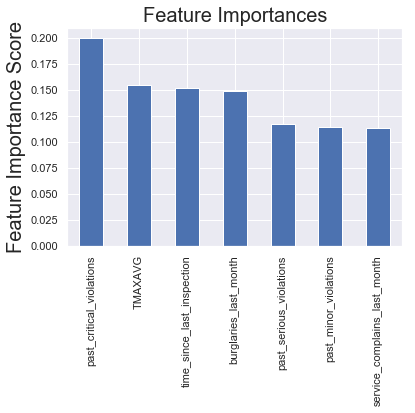

In [76]:
modelfit(clf, X_train, Y_train, True, True, 5)

In [41]:
predictors = features
gbm0 = GradientBoostingClassifier( random_state=10)
print(gbm0)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)



Model Report
Accuracy : 0.8876
AUC Score (Train): 0.943954
CV Score : Mean - 0.9107934 | Std - 0.1513346 | Min - 0.6084297 | Max - 0.9920915


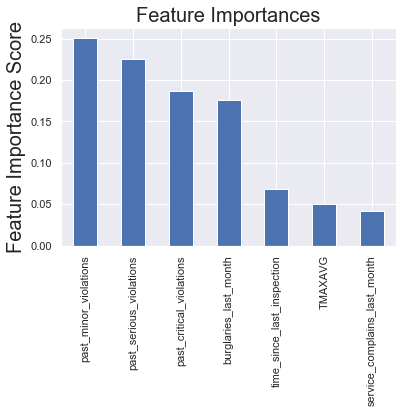

In [42]:
modelfit(gbm0, X_train, Y_train)

Accuracy = 0.7975708502024291 
F1 Score = 0.06542056074766356 
ROC-AUC Score = 0.5508027329945138 
Recall-Score = 0.03783783783783784 


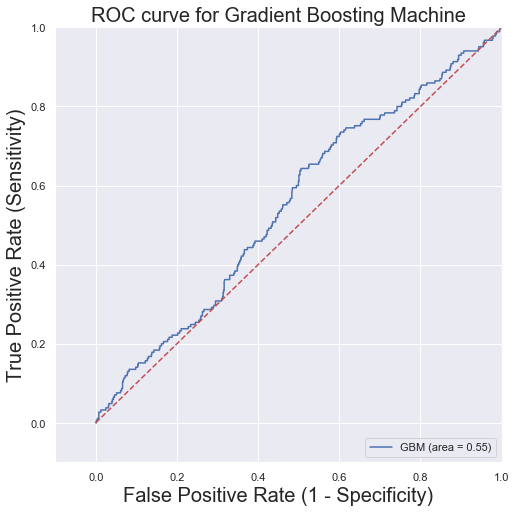

In [43]:
gbm_y_pred_test = gbm0.predict(X_test)
gbm_y_pred_test_proba = gbm0.predict_proba(X_test)[:,1]
print("Accuracy = %s " % metrics.accuracy_score(Y_test, gbm_y_pred_test))
print("F1 Score = %s " %metrics.f1_score(Y_test, gbm_y_pred_test))
print("ROC-AUC Score = %s "%metrics.roc_auc_score(Y_test, gbm_y_pred_test_proba))
print("Recall-Score = %s " %metrics.recall_score(Y_test, gbm_y_pred_test))
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, gbm_y_pred_test_proba)
plt.plot(fpr, tpr, label='GBM (area = %0.2f)' % metrics.roc_auc_score(Y_test, gbm_y_pred_test_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Gradient Boosting Machine')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [44]:
gbm_final = GradientBoostingClassifier(learning_rate=0.01, n_estimators=7,  min_samples_split=100,min_samples_leaf=30, max_depth=6,max_features='sqrt', subsample=0.8, random_state=10) 
gbm_final.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=7,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Accuracy = 0.7226720647773279 
F1 Score = 0.2594594594594595 
ROC-AUC Score = 0.5535155329675878 
Recall-Score = 0.2594594594594595 


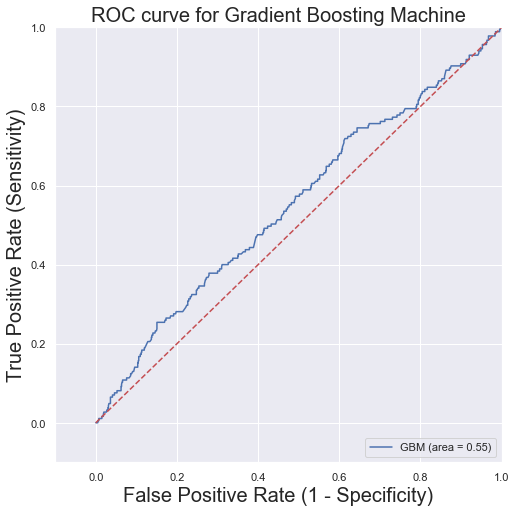

In [45]:
gbm_final_y_pred_test = gbm_final.predict(X_test)
gbm_final_y_pred_test_proba = gbm_final.predict_proba(X_test)[:,1]
print("Accuracy = %s " % metrics.accuracy_score(Y_test, gbm_final_y_pred_test))
print("F1 Score = %s " %metrics.f1_score(Y_test, gbm_final_y_pred_test))
print("ROC-AUC Score = %s "%metrics.roc_auc_score(Y_test, gbm_final_y_pred_test_proba))
print("Recall-Score = %s " %metrics.recall_score(Y_test, gbm_final_y_pred_test))
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, gbm_final_y_pred_test_proba)
plt.plot(fpr, tpr, label='GBM (area = %0.2f)' % metrics.roc_auc_score(Y_test, gbm_final_y_pred_test_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Gradient Boosting Machine')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

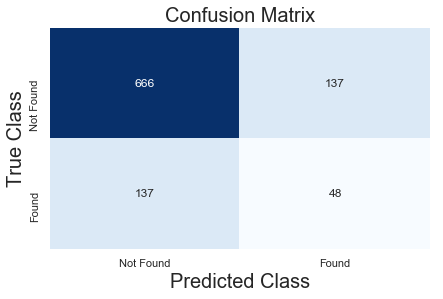

In [46]:
class_names = ['Not Found', 'Found']
matrix = metrics.confusion_matrix(Y_test, gbm_final_y_pred_test)
# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [79]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'eval_metric': ['auc'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 18, 20, 25],
    'n_estimators': [100, 200, 300, 500, 1000]
}
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=101)
xgb_grid_search = RandomizedSearchCV(estimator = xgb_model, param_distributions= param_grid, 
                         cv = 5, random_state=101, n_jobs = -1)
xgb_grid_search.fit(X_train.as_matrix(), Y_train)
#Best estimator and CV score
print('Best Accuracy score ', xgb_grid_search.best_score_)
print(xgb_grid_search.best_estimator_)

xgb_model = xgb_grid_search.best_estimator_
#X_test = X_test[X_train.columns]
xgb_y_pred = xgb_model.predict(X_test.as_matrix())
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:,1]
print("Accuracy = %s " % metrics.accuracy_score(Y_test, xgb_y_pred))
print("F1 Score = %s " %metrics.f1_score(Y_test, xgb_y_pred))
print("ROC-AUC Score = %s "%metrics.roc_auc_score(Y_test, xgb_y_pred_proba))
print("Recall-Score = %s " %metrics.recall_score(Y_test, xgb_y_pred))
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, xgb_y_pred_proba)
plt.plot(fpr, tpr, label='GBM (area = %0.2f)' % metrics.roc_auc_score(Y_test, xgb_y_pred_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.0])
plt.rcParams['font.size'] = 12
plt.title(' Validation ROC curve for Gradient Boosting Machine')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'as_matrix'

In [ ]:
# Validation Set
X_valid = food_business_test_sample[features]
Y_valid = food_business_test_sample['CriticalFound']
#X_valid = scaler.fit_transform(X_valid)
xgb_y_valid = xgb_model.predict(X_valid)
xgb_y_valid_proba = xgb_model.predict_proba(X_valid)[:,1]
print("Accuracy = %s " % metrics.accuracy_score(Y_valid, xgb_y_valid))
print("F1 Score = %s " %metrics.f1_score(Y_valid, xgb_y_valid))
print("ROC-AUC Score = %s "%metrics.roc_auc_score(Y_valid, xgb_y_valid_proba))
print("Recall-Score = %s " %metrics.recall_score(Y_test, xgb_y_valid))
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_valid, xgb_y_valid_proba)
plt.plot(fpr, tpr, label='GBM (area = %0.2f)' % metrics.roc_auc_score(Y_valid, xgb_y_valid_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.0])
plt.rcParams['font.size'] = 12
plt.title(' Validation ROC curve for Gradient Boosting Machine')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
y_valid_rf = clf.predict(X_valid)
y_valid_proba_rf = clf.predict_proba(X_valid)[:,1]
print("Accuracy = %s " % metrics.accuracy_score(Y_valid, y_valid_rf))
print("F1 Score = %s " %metrics.f1_score(Y_valid, y_valid_rf))
print("ROC-AUC Score = %s "%metrics.roc_auc_score(Y_valid, y_valid_proba_rf))
print("Recall-Score = %s " %metrics.recall_score(Y_test, y_valid_proba_rf))

In [ ]:
X_valid.shape